# Neighborhood Selection for a New Restaurant in New York City

## 1. Introduction

Finding an optimal location for a new restaurant in a major city like New York City can be a complex process with many factors involved. Indeed, the location of the restaurant could determine its success.

In order to find the ideal location, we will assume that we want to:
* Select the neighborhood that would maximize its proximity to high traffic venues
* Select the neighborhood with fewer competing restaurants of the same type

## 2. Data

We will gather all the neighborhoods in New York City from all 5 boroughs and their latitude and longitude coordinates.
Then we will use the Four Square API to get venues from those latitude, longitude coordinates.

In [1]:
!pip install geocoder
!pip install geopy

In [2]:
!pip install folium==0.5.0

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import requests
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [4]:
# Get table from html page
url = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
list_of_tables = pd.read_html(url, header=0)
df = list_of_tables[0]

df = df.dropna()

# Parse boroughs column
df = df.drop(['Areakm2', 'Pop.Census2010', 'Pop./km2'], axis=1)
cb = df['Community Board(CB)']
cb = cb.str.replace('(\s)CB(\s)[0-9]+$', '', regex=True)
df['Borough'] = cb
df = df.drop('Community Board(CB)', axis=1)

# Parse neighborhoods by spliting comma separated elements into separate rows
neighborhoods = df['Neighborhoods']
boroughs = df['Borough']
all_boroughs = []
all_neighborhoods = []
for i,n in enumerate(neighborhoods):
    row = n.split(',')
    for element in row:
        all_boroughs.append(boroughs[i])
        all_neighborhoods.append(element.strip())
        
d = {
    'All Boroughs': pd.Series(all_boroughs),
    'All Neighborhoods': pd.Series(all_neighborhoods)
}
df_parsed = pd.DataFrame(d)
df_parsed = df_parsed.drop_duplicates()
df_parsed

,All Boroughs,All Neighborhoods
0,Bronx,Melrose
1,Bronx,Mott Haven
2,Bronx,Port Morris
3,Bronx,Hunts Point
4,Bronx,Longwood
5,Bronx,Claremont
6,Bronx,Concourse Village
7,Bronx,Crotona Park
8,Bronx,Morrisania
9,Bronx,Concourse


In [5]:
# Find latitudes and longitudes for the neighborhoods

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="NYC")
latitudes = []
longitudes = []
neighborhoodId = range(1, len(all_neighborhoods))

for i,v in enumerate(all_neighborhoods):
    location = geolocator.geocode(v + "," + all_boroughs[i])
    if location is None:
        print(str(i) + " does not return a value")
        latitudes.append(None)
        longitudes.append(None)
    else:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
        
df_parsed['Latitude'] = pd.Series(latitudes)
df_parsed['Longitude'] = pd.Series(longitudes)
df_parsed['Id'] = pd.Series(neighborhoodId)
df_parsed = df_parsed.dropna()
print(df_parsed.shape)
df_parsed.head()

13 does not return a value
28 does not return a value
94 does not return a value
228 does not return a value
237 does not return a value
284 does not return a value
291 does not return a value
292 does not return a value
311 does not return a value
317 does not return a value
(307, 5)


,All Boroughs,All Neighborhoods,Latitude,Longitude,Id
0,Bronx,Melrose,40.825670,-73.915242,1.0
1,Bronx,Mott Haven,40.808990,-73.922915,2.0
2,Bronx,Port Morris,40.801515,-73.909581,3.0
3,Bronx,Hunts Point,40.812601,-73.884025,4.0
4,Bronx,Longwood,40.816292,-73.896220,5.0


In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
# Build Four Square API url endpoint usage for request
url = "https://api.foursquare.com/v2/venues/explore?client_id=" + CLIENT_ID + "&client_secret=" + CLIENT_SECRET + \
        "&ll=" + str(df_parsed.loc[0,'Latitude']) + "," + str(df_parsed.loc[0,'Longitude']) + "&limit=" + str(LIMIT) + "&v=" + VERSION + "&radius=" + str(RADIUS);
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fe9a315732a472e70fdfc46'},
 'response': {'headerLocation': 'Melrose',
  'headerFullLocation': 'Melrose, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 36,
  'suggestedBounds': {'ne': {'lat': 40.8301703045, 'lng': -73.90930584044041},
   'sw': {'lat': 40.821170295499996, 'lng': -73.9211773595596}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5956be26123a195de6701c2b',
       'name': 'Porto Salvo',
       'location': {'address': '424 E 161st St',
        'lat': 40.823887357573966,
        'lng': -73.91291020190582,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.823887357573966,
          'lng': -73.91291020190582}],
        'distance': 279,
        'postalCode': '10451',
        'cc': 

In [8]:
# Loop through all neighborhoods and get their venue data from Four Square

venues_list = []
for name, lat, lng, nid in zip(df_parsed['All Neighborhoods'], df_parsed['Latitude'], df_parsed['Longitude'], df_parsed['Id']):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        RADIUS, 
        LIMIT)
            
    # make the GET request
    try:
        results = requests.get(url).json()["response"]['groups'][0]['items']
    except:
        print(name + " has no venues")
        venues_list.append([(name, lat, lng, 'None', 'None', 'None', 'None', nid)])
        results = None
    
    # return only relevant information for each nearby venue
    if results is not None:
        print(name + " venues added")
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            nid) for v in results])        

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Neighborhood', 
                        'Neighborhood Latitude', 
                        'Neighborhood Longitude', 
                        'Venue', 
                        'Venue Latitude', 
                        'Venue Longitude', 
                        'Venue Category',
                        'Neighborhood Id']
nearby_venues.drop_duplicates()
nearby_venues.head()

Melrose venues added
Mott Haven venues added
Port Morris venues added
Hunts Point venues added
Longwood venues added
Claremont venues added
Concourse Village venues added
Crotona Park venues added
Morrisania venues added
Concourse venues added
Highbridge venues added
Fordham venues added
Morris Heights venues added
University Heights venues added
Bathgate venues added
Belmont venues added
East Tremont venues added
West Farms venues added
Bedford Park venues added
Norwood venues added
Fieldston venues added
Kingsbridge venues added
Kingsbridge Heights venues added
Marble Hill venues added
Riverdale venues added
Spuyten Duyvil venues added
Bronx River venues added
Bruckner venues added
Castle Hill venues added
Clason Point venues added
Harding Park venues added
Parkchester venues added
Soundview venues added
Unionport venues added
City Island venues added
Co-op City venues added
Locust Point venues added
Pelham Bay venues added
Silver Beach venues added
Throgs Neck venues added
Westchest

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood Id
0,Melrose,40.82567,-73.915242,Porto Salvo,40.823887,-73.912910,Italian Restaurant,1.0
1,Melrose,40.82567,-73.915242,Starbucks,40.825556,-73.918865,Coffee Shop,1.0
2,Melrose,40.82567,-73.915242,Perry Coffee Shop.,40.823181,-73.910928,Diner,1.0
3,Melrose,40.82567,-73.915242,Chipotle Mexican Grill,40.825890,-73.919534,Mexican Restaurant,1.0
4,Melrose,40.82567,-73.915242,Concourse Village,40.823697,-73.919607,Shopping Mall,1.0


Now we will select all eating venues and noneating venues from each neighborhood

In [9]:
# Find all venues that are restaurants or diners
restaurants = nearby_venues[nearby_venues['Venue Category'].str.contains('American') |
                           nearby_venues['Venue Category'].str.contains('Diner') | 
                           nearby_venues['Venue Category'].str.contains('Chinese') | 
                           nearby_venues['Venue Category'].str.contains('Italian') | 
                           nearby_venues['Venue Category'].str.contains('Japanese') | 
                           nearby_venues['Venue Category'].str.contains('Korean') | 
                           nearby_venues['Venue Category'].str.contains('French') | 
                           nearby_venues['Venue Category'].str.contains('Vietnamese') | 
                           nearby_venues['Venue Category'].str.contains('Jewish') | 
                           nearby_venues['Venue Category'].str.contains('Comfort Food') | 
                           nearby_venues['Venue Category'].str.contains('Thai') | 
                           nearby_venues['Venue Category'].str.contains('Turkish') | 
                           nearby_venues['Venue Category'].str.contains('Greek') | 
                           nearby_venues['Venue Category'].str.contains('Mexican') | 
                           nearby_venues['Venue Category'].str.contains('Sushi') | 
                           nearby_venues['Venue Category'].str.contains('Southern') | 
                           nearby_venues['Venue Category'].str.contains('Spanish') | 
                           nearby_venues['Venue Category'].str.contains('Puerto Rican') | 
                           nearby_venues['Venue Category'].str.contains('Russian') | 
                           nearby_venues['Venue Category'].str.contains('Indian') | 
                           nearby_venues['Venue Category'].str.contains('Middle Eastern') | 
                           nearby_venues['Venue Category'].str.contains('Greek') | 
                           nearby_venues['Venue Category'].str.contains('German') | 
                           nearby_venues['Venue Category'].str.contains('Fast Food') | 
                           nearby_venues['Venue Category'].str.contains('Ethiopian') | 
                           nearby_venues['Venue Category'].str.contains('Carribean') | 
                           nearby_venues['Venue Category'].str.contains('Asian') | 
                           nearby_venues['Venue Category'].str.contains('Brazilian')]
restaurants.drop_duplicates()

# Each neighborhood will have an entry specifying empty if no venues were found for it
for name, lat, long, nid in zip(df_parsed['All Neighborhoods'], df_parsed['Latitude'], df_parsed['Longitude'], df_parsed['Id']):
    entry_exists = False
    for rname, rlat, rlong, rid in zip(restaurants['Neighborhood'], 
                                  restaurants['Neighborhood Latitude'], 
                                  restaurants['Neighborhood Longitude'], 
                                  restaurants['Neighborhood Id']):
        if nid == rid:
            entry_exists = True
            break
    if not entry_exists:
        empty_entry = pd.DataFrame({'Neighborhood': [name],
                                    'Neighborhood Latitude': [lat],
                                    'Neighborhood Longitude': [long],
                                    'Venue': ['None'],
                                    'Venue Latitude': ['None'],
                                    'Venue Longitude': ['None'],
                                    'Venue Category': ['None'],
                                    'Neighborhood Id': [nid]})
        restaurants = pd.concat([restaurants, empty_entry])
        
print(restaurants.shape)
restaurants.head()

(1932, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood Id
0,Melrose,40.82567,-73.915242,Porto Salvo,40.8239,-73.9129,Italian Restaurant,1.0
2,Melrose,40.82567,-73.915242,Perry Coffee Shop.,40.8232,-73.9109,Diner,1.0
3,Melrose,40.82567,-73.915242,Chipotle Mexican Grill,40.8259,-73.9195,Mexican Restaurant,1.0
5,Melrose,40.82567,-73.915242,Cinco de Mayo,40.8227,-73.9116,Mexican Restaurant,1.0
6,Melrose,40.82567,-73.915242,Hungry Bird,40.8288,-73.9168,Indian Restaurant,1.0


In [10]:
# Find all non-eating venues
noneating_venues = nearby_venues[
                            nearby_venues['Venue Category'].str.contains('Art') | 
                            nearby_venues['Venue Category'].str.contains('Zoo') |
                            nearby_venues['Venue Category'].str.contains('Hotel') | 
                            nearby_venues['Venue Category'].str.contains('College') | 
                            nearby_venues['Venue Category'].str.contains('Gym') | 
                            nearby_venues['Venue Category'].str.contains('Theme') | 
                            nearby_venues['Venue Category'].str.contains('Theater') | 
                            nearby_venues['Venue Category'].str.contains('Stadium') | 
                            nearby_venues['Venue Category'].str.contains('Court') | 
                            nearby_venues['Venue Category'].str.contains('Field') | 
                            nearby_venues['Venue Category'].str.contains('Beach') | 
                            nearby_venues['Venue Category'].str.contains('Park') | 
                            nearby_venues['Venue Category'].str.contains('Plaza') | 
                            nearby_venues['Venue Category'].str.contains('River') | 
                            nearby_venues['Venue Category'].str.contains('Mall') | 
                            nearby_venues['Venue Category'].str.contains('Museum') | 
                            nearby_venues['Venue Category'].str.contains('Concert') | 
                            nearby_venues['Venue Category'].str.contains('Marina') | 
                            nearby_venues['Venue Category'].str.contains('Event Space') | 
                            nearby_venues['Venue Category'].str.contains('Trail') | 
                            nearby_venues['Venue Category'].str.contains('Auditorium') | 
                            nearby_venues['Venue Category'].str.contains('Amphitheater') | 
                            nearby_venues['Venue Category'].str.contains('Auditorium') | 
                            nearby_venues['Venue Category'].str.contains('Beach') | 
                            nearby_venues['Venue Category'].str.contains('Skating Rink') | 
                            nearby_venues['Venue Category'].str.contains('Garden') | 
                            nearby_venues['Venue Category'].str.contains('Bowling Alley') | 
                            nearby_venues['Venue Category'].str.contains('Landmark') | 
                            nearby_venues['Venue Category'].str.contains('Bookstore')]
noneating_venues.drop_duplicates()

# Each neighborhood will have an entry specifying empty if no venues were found for it
for name, lat, long, nid in zip(df_parsed['All Neighborhoods'], df_parsed['Latitude'], df_parsed['Longitude'], df_parsed['Id']):
    entry_exists = False
    for rname, rlat, rlong, rid in zip(noneating_venues['Neighborhood'], 
                                  noneating_venues['Neighborhood Latitude'], 
                                  noneating_venues['Neighborhood Longitude'], 
                                  noneating_venues['Neighborhood Id']):
        if nid == rid:
            entry_exists = True
            break
    if not entry_exists:
        empty_entry = pd.DataFrame({'Neighborhood': [name],
                                    'Neighborhood Latitude': [lat],
                                    'Neighborhood Longitude': [long],
                                    'Venue': ['None'],
                                    'Venue Latitude': ['None'],
                                    'Venue Longitude': ['None'],
                                    'Venue Category': ['None'],
                                    'Neighborhood Id': [nid]})
        noneating_venues = pd.concat([noneating_venues, empty_entry])

print(noneating_venues.shape)
noneating_venues.head()

(1329, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood Id
4,Melrose,40.82567,-73.915242,Concourse Village,40.8237,-73.9196,Shopping Mall,1.0
18,Melrose,40.82567,-73.915242,Days Inn Bronx-Yankee Stadium,40.8271,-73.912,Hotel,1.0
22,Melrose,40.82567,-73.915242,Railroad Park,40.8249,-73.9153,Park,1.0
34,Melrose,40.82567,-73.915242,The Northrose,40.824,-73.9102,Gym / Fitness Center,1.0
43,Mott Haven,40.80899,-73.922915,BronxArtSpace,40.8118,-73.9248,Art Gallery,2.0


Now we will group each neighborhood's venues and use a one hot encoded matrix to indicate the type of venue in each column

In [11]:
# Mark all restaurants in one-hot encoding

restaurants_onehot = pd.get_dummies(restaurants[['Venue Category']], prefix="", prefix_sep="")
restaurants_onehot['Id'] = restaurants['Neighborhood Id']
fixed_columns = [restaurants_onehot.columns[-1]] + list(restaurants_onehot.columns[:-1])
restaurants_onehot = restaurants_onehot[fixed_columns]
print(restaurants_onehot.shape)
restaurants_onehot.head()

(1932, 34)


,Id,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Diner,Ethiopian Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern Greek Restaurant,New American Restaurant,None,North Indian Restaurant,Puerto Rican Restaurant,Russian Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Vietnamese Restaurant
0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# Mark all non-eating venues in one-hot encoding

noneating_onehot = pd.get_dummies(noneating_venues[['Venue Category']], prefix="", prefix_sep="")
noneating_onehot['Id'] = noneating_venues['Neighborhood Id']
fixed_columns = [noneating_onehot.columns[-1]] + list(noneating_onehot.columns[:-1])
noneating_onehot = noneating_onehot[fixed_columns]
print(noneating_onehot.shape)
noneating_onehot.head()

(1329, 73)


,Id,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Auditorium,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Garden,Bike Trail,Bookstore,Botanical Garden,Bowling Alley,Boxing Gym,Climbing Gym,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Garden,Garden Center,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,History Museum,Hockey Field,Hotel,Hotel Bar,Hotel Pool,Indie Movie Theater,Indie Theater,Martial Arts School,Monument / Landmark,Movie Theater,Museum,None,Outdoor Gym,Outlet Mall,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Plaza,Public Art,River,Sculpture Garden,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,State / Provincial Park,Street Art,Tennis Court,Tennis Stadium,Theater,Theme Park,Theme Park Ride / Attraction,Track Stadium,Trail,Used Bookstore,Zoo,Zoo Exhibit
4,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Group all restaurants in a neighborhood together and get the mean venue value

restaurants_grouped = restaurants_onehot.groupby('Id').mean().reset_index()
print(restaurants_grouped.shape)
restaurants_grouped.head()

(307, 34)


,Id,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Diner,Ethiopian Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern Greek Restaurant,New American Restaurant,None,North Indian Restaurant,Puerto Rican Restaurant,Russian Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Vietnamese Restaurant
0,1.0,0.0,0.000000,0.0,0.111111,0.0,0.111111,0.0,0.333333,0.0,0.0,0.0,0.111111,0.111111,0.0,0.0,0.0,0.0,0.000000,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2.0,0.0,0.166667,0.0,0.166667,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3.0,0.0,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
3,4.0,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
4,5.0,0.0,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [14]:
# Group all non-eating venues in a neighborhood together and get the mean venue value

noneating_grouped = noneating_onehot.groupby('Id').mean().reset_index()
print(noneating_grouped.shape)
noneating_grouped.head()

(307, 73)


,Id,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Auditorium,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Garden,Bike Trail,Bookstore,Botanical Garden,Bowling Alley,Boxing Gym,Climbing Gym,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Garden,Garden Center,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,History Museum,Hockey Field,Hotel,Hotel Bar,Hotel Pool,Indie Movie Theater,Indie Theater,Martial Arts School,Monument / Landmark,Movie Theater,Museum,None,Outdoor Gym,Outlet Mall,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Plaza,Public Art,River,Sculpture Garden,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,State / Provincial Park,Street Art,Tennis Court,Tennis Stadium,Theater,Theme Park,Theme Park Ride / Attraction,Track Stadium,Trail,Used Bookstore,Zoo,Zoo Exhibit
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The Id column in these tables can be referenced with the initial borough and neighborhood table to identify the actual location

In [15]:
df_parsed.head()

,All Boroughs,All Neighborhoods,Latitude,Longitude,Id
0,Bronx,Melrose,40.825670,-73.915242,1.0
1,Bronx,Mott Haven,40.808990,-73.922915,2.0
2,Bronx,Port Morris,40.801515,-73.909581,3.0
3,Bronx,Hunts Point,40.812601,-73.884025,4.0
4,Bronx,Longwood,40.816292,-73.896220,5.0


Now we will get the 10 most frequent venues in each neighborhood to compare with each other

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [17]:
# View most frequent restaurants in each neighborhood
neighborhoods_restaurants_sorted = pd.DataFrame(columns=columns)
neighborhoods_restaurants_sorted['Id'] = restaurants_grouped['Id']

for ind in np.arange(restaurants_grouped.shape[0]):
    neighborhoods_restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(restaurants_grouped.iloc[ind, :], num_top_venues)

neighborhoods_restaurants_sorted.head()

,Id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1.0,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,Italian Restaurant,Diner,Indian Restaurant,German Restaurant,Japanese Curry Restaurant,Greek Restaurant,Vietnamese Restaurant
1,2.0,Asian Restaurant,Latin American Restaurant,Chinese Restaurant,Mexican Restaurant,Diner,Italian Restaurant,Vietnamese Restaurant,German Restaurant,Indian Restaurant,Greek Restaurant
2,3.0,Latin American Restaurant,Spanish Restaurant,Diner,Vietnamese Restaurant,French Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Ethiopian Restaurant
3,4.0,Mexican Restaurant,Spanish Restaurant,Chinese Restaurant,Vietnamese Restaurant,French Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Ethiopian Restaurant
4,5.0,Fast Food Restaurant,Latin American Restaurant,Diner,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Vietnamese Restaurant


In [18]:
# View most frequent noneating venues in each neighborhood
neighborhoods_noneating_sorted = pd.DataFrame(columns=columns)
neighborhoods_noneating_sorted['Id'] = noneating_grouped['Id']

for ind in np.arange(restaurants_grouped.shape[0]):
    neighborhoods_noneating_sorted.iloc[ind, 1:] = return_most_common_venues(noneating_grouped.iloc[ind, :], num_top_venues)

neighborhoods_noneating_sorted.head()

,Id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1.0,Hotel,Shopping Mall,Gym / Fitness Center,Park,Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space
1,2.0,Beer Garden,Art Gallery,Zoo Exhibit,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Garden
2,3.0,Performing Arts Venue,Zoo Exhibit,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court
3,4.0,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
4,5.0,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit


Here we see the top eating venues and noneating venues in each neighborhood in New York City. We can now cluster these neighborhoods so that we can see which groups of neighborhoods are similar to each other in terms of restaurants and noneating venues. We will then select the cluster that has the optimal noneating venues that indicates high traffic and select the cluster that does not have as many of the same restaurant type as the one we are trying to open.

## 3. Clustering

Find the optimal amount of k clusters in the kmeans clustering. Here we try to find the elbow point, or the point in which by increasing the k clusters causes less of a decrease in distances from centroids.

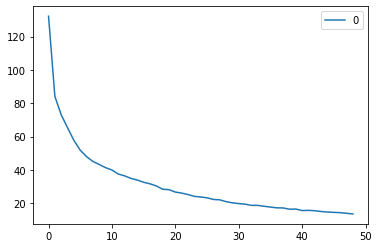

In [19]:
restaurants_grouped_clustering = restaurants_grouped.drop('Id', 1)

accuracies = np.zeros(50)

for i in range(1, len(accuracies)):
    k_means_restaurants = KMeans(init = "k-means++", n_clusters = i, n_init = 12)
    k_means_restaurants.fit(restaurants_grouped_clustering)
    accuracies[i] = k_means_restaurants.inertia_
    
df_accuracies = pd.DataFrame(data=accuracies[1:])
df_accuracies.plot()

Based on this analysis, we will select a k of 12

In [20]:
kclusters = 12

# run k-means clustering on restaurants
kmeans_restaurants = KMeans(n_clusters=kclusters, random_state=0).fit(restaurants_grouped_clustering)

neighborhoods_restaurants_sorted.insert(0, 'Cluster Labels', kmeans_restaurants.labels_)

restaurants_merged = df_parsed
restaurants_merged = restaurants_merged.join(neighborhoods_restaurants_sorted.set_index('Id'), on='Id')

restaurants_merged.head()

,All Boroughs,All Neighborhoods,Latitude,Longitude,Id,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Melrose,40.825670,-73.915242,1.0,2,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,Italian Restaurant,Diner,Indian Restaurant,German Restaurant,Japanese Curry Restaurant,Greek Restaurant,Vietnamese Restaurant
1,Bronx,Mott Haven,40.808990,-73.922915,2.0,0,Asian Restaurant,Latin American Restaurant,Chinese Restaurant,Mexican Restaurant,Diner,Italian Restaurant,Vietnamese Restaurant,German Restaurant,Indian Restaurant,Greek Restaurant
2,Bronx,Port Morris,40.801515,-73.909581,3.0,7,Latin American Restaurant,Spanish Restaurant,Diner,Vietnamese Restaurant,French Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Ethiopian Restaurant
3,Bronx,Hunts Point,40.812601,-73.884025,4.0,8,Mexican Restaurant,Spanish Restaurant,Chinese Restaurant,Vietnamese Restaurant,French Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Ethiopian Restaurant
4,Bronx,Longwood,40.816292,-73.896220,5.0,7,Fast Food Restaurant,Latin American Restaurant,Diner,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Vietnamese Restaurant


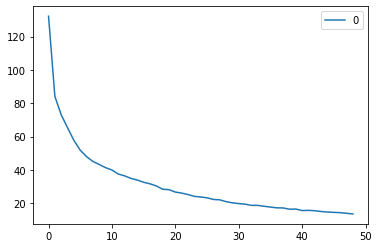

In [21]:
noneating_grouped_clustering = noneating_grouped.drop('Id', 1)

accuracies2 = np.zeros(50)

for i in range(1, len(accuracies2)):
    k_means_noneating = KMeans(init = "k-means++", n_clusters = i, n_init = 12)
    k_means_noneating.fit(noneating_grouped_clustering)
    accuracies2[i] = k_means_noneating.inertia_
    
df_accuracies2 = pd.DataFrame(data=accuracies[1:])
df_accuracies2.plot()

In [22]:
# run k-means clustering on non-eating venues

kmeans_noneating = KMeans(n_clusters=kclusters, random_state=0).fit(noneating_grouped_clustering)

neighborhoods_noneating_sorted.insert(0, 'Cluster Labels', kmeans_noneating.labels_)

noneating_merged = df_parsed
noneating_merged = noneating_merged.join(neighborhoods_noneating_sorted.set_index('Id'), on='Id')

noneating_merged.head()

,All Boroughs,All Neighborhoods,Latitude,Longitude,Id,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Melrose,40.825670,-73.915242,1.0,8,Hotel,Shopping Mall,Gym / Fitness Center,Park,Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space
1,Bronx,Mott Haven,40.808990,-73.922915,2.0,0,Beer Garden,Art Gallery,Zoo Exhibit,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Garden
2,Bronx,Port Morris,40.801515,-73.909581,3.0,0,Performing Arts Venue,Zoo Exhibit,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court
3,Bronx,Hunts Point,40.812601,-73.884025,4.0,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
4,Bronx,Longwood,40.816292,-73.896220,5.0,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit


## 4. Visualize Clusters on a Map

Restaurant Clusters on a map

In [23]:
# create map
map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, cluster in zip(restaurants_merged['Latitude'], restaurants_merged['Longitude'], restaurants_merged['All Neighborhoods'], restaurants_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Non-eating venue clusters on a map

In [24]:
# create map
map_clusters2 = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, cluster in zip(noneating_merged['Latitude'], noneating_merged['Longitude'], noneating_merged['All Neighborhoods'], noneating_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

## 5. View Cluster Members

### Clusters of Interest

#### Restaurant Cluster 1

Neighborhoods in which there were no restaurants was the most frequent, these could be a good opportunity to be the only restaurant in the area

In [25]:
restaurants_merged.loc[restaurants_merged['Cluster Labels'] == 1, restaurants_merged.columns[[0,1] + list(range(5, restaurants_merged.shape[1]))]]

,All Boroughs,All Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Bronx,Highbridge,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant
22,Bronx,Fieldston,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant
26,Bronx,Riverdale,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant
33,Bronx,Harding Park,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant
46,Bronx,Indian Village,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant
77,Brooklyn,Cypress Hills,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant
79,Brooklyn,Highland Park,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant
95,Brooklyn,Wingate,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant
117,Brooklyn,Gerritsen Beach,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant
121,Brooklyn,Madison,1,None,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant,Jewish Restaurant


#### Restaurant Cluster 9

High frequency of Italian Restaurants compared to other types of restaurants in the neighborhood

In [26]:
restaurants_merged.loc[restaurants_merged['Cluster Labels'] == 9, restaurants_merged.columns[[0,1] + list(range(5, restaurants_merged.shape[1]))]]

,All Boroughs,All Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Bronx,City Island,9,American Restaurant,French Restaurant,Italian Restaurant,Spanish Restaurant,Diner,Japanese Curry Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Ethiopian Restaurant
40,Bronx,Pelham Bay,9,Italian Restaurant,Thai Restaurant,Asian Restaurant,Latin American Restaurant,Mexican Restaurant,Diner,Vietnamese Restaurant,German Restaurant,Indian Restaurant,Greek Restaurant
51,Bronx,Van Nest,9,Italian Restaurant,Diner,Middle Eastern Restaurant,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Fast Food Restaurant
57,Bronx,Wakefield,9,American Restaurant,Italian Restaurant,Jewish Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Diner,Ethiopian Restaurant,Fast Food Restaurant
67,Brooklyn,Dumbo,9,American Restaurant,Italian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Japanese Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant
69,Brooklyn,Fulton Ferry,9,American Restaurant,Italian Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Japanese Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant
82,Brooklyn,Carroll Gardens,9,Italian Restaurant,Chinese Restaurant,American Restaurant,Thai Restaurant,Sushi Restaurant,Greek Restaurant,Mexican Restaurant,Latin American Restaurant,Asian Restaurant,Brazilian Restaurant
133,Brooklyn,Bergen Beach,9,American Restaurant,Sushi Restaurant,Italian Restaurant,Fast Food Restaurant,Japanese Curry Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Ethiopian Restaurant
135,Brooklyn,Flatlands,9,Italian Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Diner,Jewish Restaurant,Brazilian Restaurant,Comfort Food Restaurant,Ethiopian Restaurant,Fast Food Restaurant
140,Manhattan,Battery Park City,9,Italian Restaurant,Mexican Restaurant,American Restaurant,Sushi Restaurant,Diner,Japanese Restaurant,French Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant


#### Restaurant Cluster 2

High frequency of Fast Food Restaurants in this cluster

In [27]:
restaurants_merged.loc[restaurants_merged['Cluster Labels'] == 2, restaurants_merged.columns[[0,1] + list(range(5, restaurants_merged.shape[1]))]]

,All Boroughs,All Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Melrose,2,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,Italian Restaurant,Diner,Indian Restaurant,German Restaurant,Japanese Curry Restaurant,Greek Restaurant,Vietnamese Restaurant
5,Bronx,Claremont,2,Fast Food Restaurant,Vietnamese Restaurant,Jewish Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Diner,Ethiopian Restaurant,French Restaurant
8,Bronx,Morrisania,2,Fast Food Restaurant,Spanish Restaurant,Vietnamese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Ethiopian Restaurant
29,Bronx,Bronx River,2,American Restaurant,Fast Food Restaurant,Jewish Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Diner,Ethiopian Restaurant,French Restaurant
30,Bronx,Bruckner,2,Fast Food Restaurant,Mexican Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Vietnamese Restaurant,Jewish Restaurant
38,Bronx,Co-op City,2,Fast Food Restaurant,Spanish Restaurant,Chinese Restaurant,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant
44,Bronx,Allerton,2,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Vietnamese Restaurant
49,Bronx,Pelham Gardens,2,Fast Food Restaurant,Italian Restaurant,Vietnamese Restaurant,Jewish Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Diner,Ethiopian Restaurant
53,Bronx,Edenwald,2,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Jewish Restaurant,Asian Restaurant,Brazilian Restaurant,Comfort Food Restaurant,Diner,Ethiopian Restaurant,French Restaurant
55,Bronx,Fish Bay,2,American Restaurant,Fast Food Restaurant,Chinese Restaurant,Jewish Restaurant,Asian Restaurant,Brazilian Restaurant,Comfort Food Restaurant,Diner,Ethiopian Restaurant,French Restaurant


#### Restaurant Venue Cluster 5

These neighborhoods have high frequency of Sushi Restaurants

In [28]:
restaurants_merged.loc[restaurants_merged['Cluster Labels'] == 5, restaurants_merged.columns[[0,1] + list(range(5, restaurants_merged.shape[1]))]]

,All Boroughs,All Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
90,Brooklyn,Crown Heights,5,Japanese Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Vietnamese Restaurant
97,Brooklyn,Dyker Heights,5,Sushi Restaurant,Italian Restaurant,Diner,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Ethiopian Restaurant
106,Brooklyn,Ocean Parkway,5,Sushi Restaurant,Korean Restaurant,Diner,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Ethiopian Restaurant
118,Brooklyn,Homecrest,5,Sushi Restaurant,American Restaurant,Chinese Restaurant,Russian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,French Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant
120,Brooklyn,Kings Highway,5,Sushi Restaurant,Fast Food Restaurant,Turkish Restaurant,Mexican Restaurant,Russian Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,French Restaurant,Indian Restaurant,Greek Restaurant
124,Brooklyn,Sheepshead Bay,5,Sushi Restaurant,Diner,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,Russian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant
127,Brooklyn,Ditmas Village,5,Sushi Restaurant,Chinese Restaurant,Vietnamese Restaurant,French Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,Ethiopian Restaurant
195,Queens,Steinway,5,Sushi Restaurant,Italian Restaurant,Greek Restaurant,American Restaurant,Southern / Soul Food Restaurant,Chinese Restaurant,Japanese Restaurant,French Restaurant,Indian Restaurant,German Restaurant
224,Queens,Briarwood,5,Sushi Restaurant,Diner,Spanish Restaurant,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant
314,Staten Island,Todt Hill,5,Sushi Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Japanese Curry Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Ethiopian Restaurant


#### Noneating Venue Cluster 8

Relatively high frequency of parks

In [29]:
noneating_merged.loc[noneating_merged['Cluster Labels'] == 8, noneating_merged.columns[[0,1] + list(range(5, noneating_merged.shape[1]))]]

,All Boroughs,All Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Melrose,8,Hotel,Shopping Mall,Gym / Fitness Center,Park,Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space
20,Bronx,Norwood,8,Park,History Museum,Gym,Museum,Gym Pool,Gym / Fitness Center,Gymnastics Gym,Garden Center,Garden,College Bookstore
26,Bronx,Riverdale,8,River,Shopping Mall,Park,Event Space,College Bookstore,College Cafeteria,College Rec Center,College Theater,Concert Hall,Field
27,Bronx,Spuyten Duyvil,8,Tennis Court,Park,Tennis Stadium,Food Court,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field
37,Bronx,City Island,8,History Museum,Harbor / Marina,Arts & Crafts Store,Baseball Field,Park,Food Court,College Rec Center,College Theater,Concert Hall,Event Space
42,Bronx,Throgs Neck,8,Park,Bookstore,Zoo Exhibit,College Bookstore,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court
43,Bronx,Westchester Square,8,Indie Theater,Baseball Field,Park,Gym,Zoo Exhibit,Food Court,College Rec Center,College Theater,Concert Hall,Event Space
45,Bronx,Bronxdale,8,Shopping Mall,Gym / Fitness Center,Park,Garden,Zoo Exhibit,Event Space,College Cafeteria,College Rec Center,College Theater,Concert Hall
51,Bronx,Van Nest,8,Bowling Alley,Park,Zoo Exhibit,College Bookstore,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court
58,Bronx,Williamsbridge,8,Park,History Museum,Gym,Museum,Gym Pool,Gym / Fitness Center,Gymnastics Gym,Garden Center,Garden,College Bookstore


#### Noneating Venue Cluster 1

No high traffic noneating venues

In [30]:
noneating_merged.loc[noneating_merged['Cluster Labels'] == 1, noneating_merged.columns[[0,1] + list(range(5, noneating_merged.shape[1]))]]

,All Boroughs,All Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bronx,Hunts Point,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
4,Bronx,Longwood,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
10,Bronx,Highbridge,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
15,Bronx,Bathgate,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
30,Bronx,Bruckner,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
36,Bronx,Unionport,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
50,Bronx,Pelham Parkway,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
53,Bronx,Edenwald,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
57,Bronx,Wakefield,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit
59,Bronx,Woodlawn Heights,1,None,Hockey Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court,Zoo Exhibit


#### Noneating Venue Cluster 5

Most frequent non-eating venue are gyms

In [32]:
noneating_merged.loc[noneating_merged['Cluster Labels'] == 5, noneating_merged.columns[[0,1] + list(range(5, noneating_merged.shape[1]))]]

,All Boroughs,All Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Bronx,Fordham,5,Plaza,Gym / Fitness Center,Park,Theater,Event Space,College Bookstore,College Cafeteria,College Rec Center,College Theater,Concert Hall
40,Bronx,Pelham Bay,5,Gym / Fitness Center,Zoo Exhibit,Food Court,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Garden
49,Bronx,Pelham Gardens,5,Gym / Fitness Center,Gym,Zoo Exhibit,Food Court,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field
91,Brooklyn,Prospect Heights,5,Gym / Fitness Center,Plaza,Event Space,Garden Center,Garden,Used Bookstore,Gym Pool,Gymnastics Gym,Gym,Harbor / Marina
98,Brooklyn,Fort Hamilton,5,Gym / Fitness Center,Beer Garden,Gym,Zoo Exhibit,College Rec Center,College Theater,Concert Hall,Event Space,Field,Food Court
99,Brooklyn,Bath Beach,5,Gym / Fitness Center,Zoo Exhibit,Food Court,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Garden
100,Brooklyn,Bensonhurst,5,Gym / Fitness Center,Zoo Exhibit,Food Court,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Garden
112,Brooklyn,Flatbush,5,Gym / Fitness Center,Gym,Park,Zoo Exhibit,Field,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space
119,Brooklyn,Kings Bay,5,Gym / Fitness Center,Zoo Exhibit,Food Court,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field,Garden
120,Brooklyn,Kings Highway,5,Gym / Fitness Center,Gym,Zoo Exhibit,Food Court,College Cafeteria,College Rec Center,College Theater,Concert Hall,Event Space,Field
